# Маркетинговая аналитика Яндекс.Афиши

Задание проекта: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

В проекте предстоит изучить:
- как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.

Выручка измеряется в условных единицах — у.е.

## Содержание

1. [Шаг 1. Загрузка данных и подготовка их к анализу](#Шаг1)
2. [Шаг 2. Рассчет метрик и построение графиков](#Шаг2)
 1. [2.1 Продуктовые метрики](#Шаг21)
 2. [2.2 Метрики электронной коммерции](#Шаг22)
 3. [2.3 Маркетинговые метрики](#Шаг23)
3. [Шаг 3. Выводы и рекомендации](#Шаг3)

## Шаг 1. Загрузка данных и подготовка их к анализу <a name=Шаг1></a>

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
visits_log = pd.read_csv('visits_log.csv')
orders_log = pd.read_csv('orders_log.csv')
costs = pd.read_csv('costs.csv')

Посмотрим на данные в загруженных датасетах, начнем по порядку с первого датасета, который содержит информацию о посещениях сайта.

In [3]:
visits_log.sample(10)

Device               End Ts  Source Id             Start Ts  \
280405  desktop  2017-07-15 10:46:00          2  2017-07-15 10:46:00   
283496    touch  2017-06-05 18:30:00         10  2017-06-05 18:13:00   
298280  desktop  2017-11-24 03:43:00          5  2017-11-24 03:32:00   
108125  desktop  2017-12-13 17:00:00          4  2017-12-13 16:57:00   
80758     touch  2018-04-05 16:14:00          4  2018-04-05 16:13:00   
119288  desktop  2018-01-10 11:02:00          5  2018-01-10 10:58:00   
302323  desktop  2018-05-26 13:03:00          4  2018-05-26 12:15:00   
180421    touch  2018-02-25 23:08:00          3  2018-02-25 22:55:00   
353887  desktop  2017-12-11 14:38:00          1  2017-12-11 14:20:00   
175094  desktop  2018-02-10 12:19:00          4  2018-02-10 12:18:00   

                         Uid  
280405  18027222598828835800  
283496  13759586366795757082  
298280   1612240711669547921  
108125  11565073715117975094  
80758   14217532149251099532  
119288   2749049376926190572  
302323   3827256148372510526  
180421    920421432978813311  
353887   4725491913940272589  
175094  12486316941673148377

In [4]:
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Сразу обращаем внимание на названия колонок, их нужно будет переименовать для более удобной работы. Также изменим тип данных в колонках с началом и концом сессии на формат для даты и времени. Колонка с источником трафика содержит только положительные целые числа от 1 до 10, можно изменить тип данных на **uint8** - это позволит уменьшить размер файла, что немного ускорит обработку запросов.

In [5]:
visits_log.set_axis(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], axis=1, inplace=True)

In [6]:
visits_log['source_id'] = visits_log['source_id'].astype('uint8')

In [7]:
visits_log['end_ts'] = pd.to_datetime(visits_log['end_ts'])
visits_log['start_ts'] = pd.to_datetime(visits_log['start_ts'])

In [8]:
visits_log.sample(5)

device              end_ts  source_id            start_ts  \
333569    touch 2018-05-31 14:05:00          1 2018-05-31 14:04:00   
88219   desktop 2017-08-15 19:47:00          3 2017-08-15 19:46:00   
91284   desktop 2018-04-11 10:19:00          3 2018-04-11 10:18:00   
344631  desktop 2017-12-05 18:22:00          5 2017-12-05 18:21:00   
189088  desktop 2017-11-13 08:54:00          3 2017-11-13 08:47:00   

                        uid  
333569  3379459152254523328  
88219   7929810668639995262  
91284   6479831434049374684  
344631   402639008551429168  
189088  6515442583371655599

In [9]:
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  uint8         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), object(1), uint64(1), uint8(1)
memory usage: 11.3+ MB


Посмотрим на данные во втором датасете, который содержит информацию о заказах.

In [10]:
orders_log.sample(10)

Buy Ts  Revenue                   Uid
25820  2017-12-24 21:04:00     2.78   2592509942095994178
14038  2017-10-22 17:32:00     1.22  13888745432979765063
10555  2017-10-04 13:09:00     2.20  13752293881932194478
46916  2018-05-10 22:36:00     3.05  10790606934980413781
27018  2017-12-29 18:13:00     2.93  15591065211799077020
49615  2018-05-30 09:18:00     0.85  13721124036615348696
20835  2017-11-28 23:01:00    26.83   4975215853282774891
39358  2018-03-10 22:31:00     2.14  12976611525803667251
15720  2017-11-01 21:56:00     1.83   6953534127137302513
15475  2017-10-31 13:07:00     9.78   9387706611667293932

In [11]:
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Здесь снова нужно будет изменить названия колонок на более удобные для работы, а также изменить тип колонки с информацией о времени покупки на формат для даты и времени.

In [12]:
orders_log.set_axis(['buy_ts', 'revenue', 'uid'], axis=1, inplace=True)

In [13]:
orders_log['buy_ts'] = pd.to_datetime(orders_log['buy_ts'])

In [14]:
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


Переходим к изучению данных в третьем датасете с информацией о расходах на рекламу.

In [15]:
costs.sample(10)

source_id          dt   costs
777           3  2017-07-22  182.17
1165          4  2017-08-16  228.72
1156          4  2017-08-07    8.36
1833          9  2017-06-18    9.44
387           2  2017-06-25   60.33
1046          3  2018-04-19  603.70
660           2  2018-03-25  125.00
2395         10  2018-01-03   27.45
1748          5  2018-03-24  155.64
973           3  2018-02-03  475.90

In [16]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


В этом случае названия колонок менять не нужно, они нас устраивают. Изменим тип данных в колонке с датой совершения расхода на формат для дат, также изменим тип данных в колокне с источниками трафика на **uint8**.

In [17]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs['source_id'] = costs['source_id'].astype('uint8')

In [18]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   uint8         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), uint8(1)
memory usage: 42.3 KB


**Вывод**

В представленных датасетах в двух случая из трех нужно было изменить названия колонок для удобной работы в дальнейшем, скорее всего их такими задали при изначальной выгрузке данных. Пропусков нет, что говорит об отсутвии технических неполадок на этапе выгрузки данных.
Изменили тип данных на формат для даты и времени для всех колонок, которые содержат такую информацию. Также для колонок с источниками трафика изменили формат на **uint8**, что позволило немного уменьшить размер файлов. 

## Шаг 2. Рассчет метрик и построение графиков <a name=Шаг2></a>

### 2.1 Продуктовые метрики <a name=Шаг21></a>

- Рассчитаем показатели DAU, WAU и MAU. Вычислим средние значения этих метрик за весь период.

In [19]:
visits_log['session_date'] = visits_log['start_ts'].dt.date
visits_log['session_date'] = pd.to_datetime(visits_log['session_date'])
visits_log['session_month_date'] = visits_log['session_date'].astype('datetime64[M]')
visits_log['session_week_date'] = pd.to_datetime(visits_log['session_date'], unit='d') - pd.to_timedelta(visits_log['session_date'].dt.dayofweek, unit='d')

In [20]:
dau = visits_log.groupby('session_date').agg({'uid': 'nunique'}).reset_index()
wau = visits_log.groupby('session_week_date').agg({'uid': 'nunique'}).reset_index()
mau = visits_log.groupby('session_month_date').agg({'uid': 'nunique'}).reset_index()

In [21]:
dau_total = dau['uid'].mean()
wau_total = wau['uid'].mean()
mau_total = mau['uid'].mean()

In [22]:
print('Среднее значение DAU за весь период:', int(dau_total))
print('Среднее значение WAU за весь период:', int(wau_total))
print('Среднее значение MAU за весь период:', int(mau_total))

Среднее значение DAU за весь период: 907
Среднее значение WAU за весь период: 5716
Среднее значение MAU за весь период: 23228


In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dau['session_date'], y=dau['uid'], mode="lines", showlegend=True, name='DAU'))
fig.add_trace(go.Scatter(x=wau['session_week_date'], y=wau['uid'], mode="lines", showlegend=True, name='WAU'))
fig.add_trace(go.Scatter(x=mau['session_month_date'], y=mau['uid'], mode="lines", showlegend=True, name='MAU'))
fig.update_layout(title='Показатели DAU, WAU и MAU за период с июня 2017 по конец мая 2018 года', xaxis_title='Период', yaxis_title='Количество уникальных пользователей')
fig.show()

В целом в рамках периода наблюдается рост числа уникальных пользователей, о чем говорят все из рассмотренных метрик. На графике DAU можно видеть, что график идет небольшим зигзагом, что говорит о том, что число уникальных пользователей постоянно колеблется и, возможно, новые притоки происходят после каких-то рассылок или реклам, затем кто-то отваливается, потом выходит новая маркетинговая акция, начинается новый наплыв и так далее. Но безусловно в рамках года платформа расширяется, число уникальных пользователей выросло, значит пользователей, которые остались на регулярной основе, больше.
Очень заметен аномальный пик 24 ноября 2017 года, число уникальных пользователей в этот день увеличилось практически в 3 раза от обычных показателей. Возможно, это была какая-то крупная маркетинговая акция, но она не позволила удержать интерес и на следующий день новоприбывшие пользователи уже не нуждались в услугах платформы. А может причина не в этом и пользователи заходили на сайт по ошибке, или это был однодневный интерес, связанный с каким-то событием.

- Определим, сколько раз за день пользователи в среднем заходят на сайт.

In [24]:
print('Среднее количество посещений сайта за день:', int(visits_log.groupby('session_date').agg({'start_ts': 'count'}).mean()))

Среднее количество посещений сайта за день: 987


In [25]:
fig = px.line(visits_log.pivot_table(index='session_date', values='start_ts', aggfunc='count').reset_index(), x='session_date', y='start_ts')
fig.update_layout(title='Количество посещений сайта за каждый день', xaxis_title='Период', yaxis_title='Количество посещений сайта')
fig.show()

Среднее количество посещений сайта за день лишь немного больше количества уникальных пользователей за день, что говорит нам о том, что, как правило, пользователю хватает одной сессии. Мало кто заходит по два раза в день.

- Исследуем, сколько времени пользователи проводят на сайте. Узнаем продолжительность типичной пользовательской сессии за весь период.

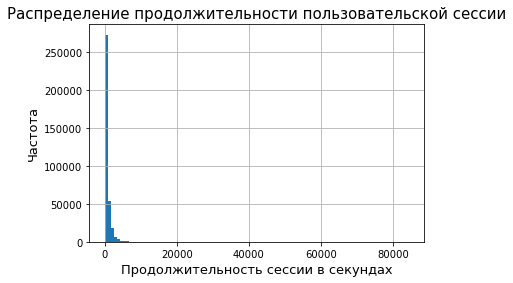

In [26]:
visits_log['session_duration_sec'] = (visits_log['end_ts'] - visits_log['start_ts']).dt.seconds
visits_log['session_duration_sec'].hist(bins=100)
plt.title('Распределение продолжительности пользовательской сессии', size=15)
plt.xlabel('Продолжительность сессии в секундах', size=13)
plt.ylabel('Частота', size=13)
plt.show()

Длина сессий распределена неравномерно, поэтому чтобы узнать продолжительность типичной пользовательской сессии за весь период пользоваться такими показателями как среднее значение или медиана мы не можем. Рассчитаем моду.

In [27]:
print('Продолжительность типичной пользовательской сессии:', int(visits_log['session_duration_sec'].mode()), 'секунд')

Продолжительность типичной пользовательской сессии: 60 секунд


В среднем пользватели проводят на сайте 60 секунд, не очень много, но скорее всего этого времени хватает, чтобы сделать заказ.

- Рассчитаем Retention Rate, применяя когортный анализ. Найдем средний Retention Rate на второй месяц «жизни» когорт.

In [28]:
first_visit_date = visits_log.groupby('uid')['start_ts'].min()
first_visit_date.name = 'first_visit_date'
visits_log = visits_log.join(first_visit_date, on='uid')
visits_log['first_visit_month'] = visits_log['first_visit_date'].astype('datetime64[M]')

visits_log['cohort_lifetime'] = visits_log['session_month_date'] - visits_log['first_visit_month']
visits_log['cohort_lifetime'] = visits_log['cohort_lifetime'] / np.timedelta64(1, 'M')
visits_log['cohort_lifetime'] = visits_log['cohort_lifetime'].round().astype('int')

In [29]:
cohorts = visits_log.groupby(['first_visit_month', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month', 'uid']]
initial_users_count = initial_users_count.rename(columns = {'uid': 'cohort_users'})
cohorts = cohorts.merge(initial_users_count, on='first_visit_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']
cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m-%d')

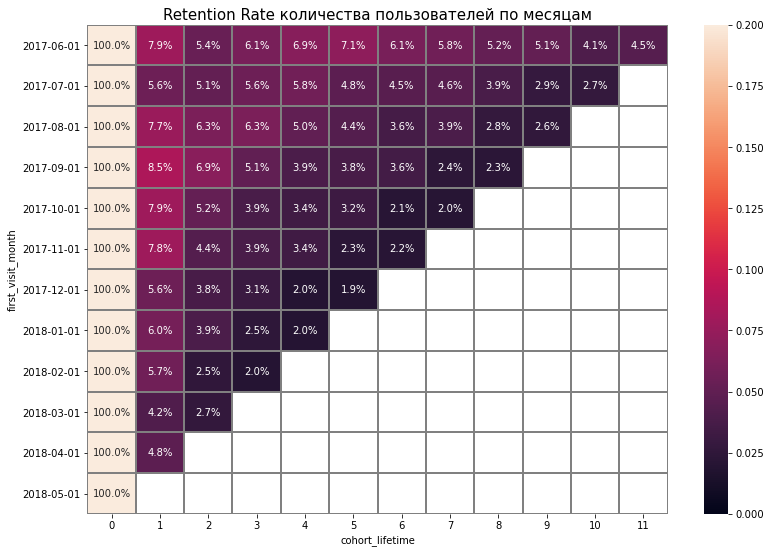

In [30]:
retention_pivot = cohorts.pivot_table(index='first_visit_month', columns='cohort_lifetime', values='retention', aggfunc='sum')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate количества пользователей по месяцам', size=15)
sns.heatmap(retention_pivot, vmin=0, vmax=0.2, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.show()

In [31]:
print('Средние значения Retention Rate по всем возрастам когорт')
cohorts.pivot_table(index='cohort_lifetime', values='retention', aggfunc='mean').style.format({'retention': '{:.2%}'})

Средние значения Retention Rate по всем возрастам когорт


In [32]:
print('Средний Retention Rate на второй месяц «жизни» когорт: {:.1%}'.format(cohorts[cohorts['cohort_lifetime'] == 1]['retention'].mean()))

Средний Retention Rate на второй месяц «жизни» когорт: 6.5%


На второй месяц с момента первого посещения сайта остаются в среднем 6% пользователей. Конечно, билеты на концерт или в театр - это не то, что большинство людей покупают на регулярной основе, такие покупки скорее происходят более ситуативно.

Retention Rate в нашей ситуации держится в пределах 9%, но все таки можно заметить, что самый высокий показатель во второй месяц "жизни" когорты, а далее показатель только уменьшается и падает примерно до 2% с наступлением лета.

**Вывод**

Значительный рост числа уникальных пользователей происходит с августа 2017 года, а после ноября наблюдается спад, то есть значит, что сайт стали посещать меньше людей. Однако, показатель DAU в общем подрос за рассматриваемый период, значит, что одни и те же люди стали немного больше заходить на сайт, а на один визит в среднем пользователям хватает минуты. Не такой большой процент людей готовы снова возвращаться на сайт, с каждым последующим месяцем с момента первого визита, на сайт возвращается все меньше клиентов.

### 2.2 Метрики электронной коммерции <a name=Шаг22></a>

- Исследуем, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки.

In [33]:
first_buy_date = orders_log.groupby('uid')['buy_ts'].min()
first_buy_date.name = 'first_buy_date'
orders_log = orders_log.join(first_buy_date, on='uid')

In [34]:
visits_log = visits_log.merge(orders_log[['uid', 'first_buy_date']], how='right', on='uid')

In [35]:
visits_log['duration_to_first_order'] = (visits_log['first_buy_date'] - visits_log['first_visit_date']).dt.seconds

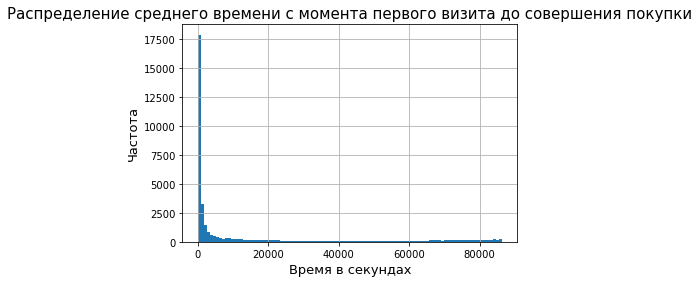

In [36]:
visits_log.groupby('uid')['duration_to_first_order'].min().hist(bins=100)
plt.title('Распределение среднего времени с момента первого визита до совершения покупки', size=15)
plt.xlabel('Время в секундах', size=13)
plt.ylabel('Частота', size=13)
plt.show()

In [37]:
visits_log['duration_to_first_order'].mode()

0    0
dtype: int64

Построив диаграмму распределения и убедившись еще раз рассчитав моду видно, что довольно большая часть покупок происходит не на страничке сайта, так как за 0 секунд успеть оформить заказ на сайте невозможно. Помним, что стандартная сессия длится 60 секунд, значит у нас есть информация о покупателях, которые как-то по-другому оформляют заказы. Такое может быть если пользователи оплачивают сразу по прямым ссылкам на почту, не заходя на сайт, либо совершают покупки на сайтах-партнерах.

Посмотрим еще раз на время с момента первого посещения сайта до совершения покупки без учета нулевых данных.

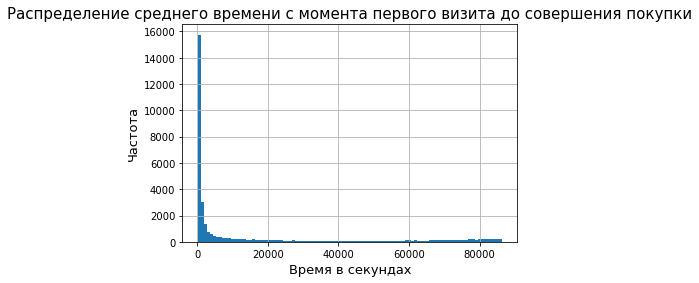

In [38]:
visits_log.query('duration_to_first_order != 0').groupby('uid')['duration_to_first_order'].min().hist(bins=100)
plt.title('Распределение среднего времени с момента первого визита до совершения покупки', size=15)
plt.xlabel('Время в секундах', size=13)
plt.ylabel('Частота', size=13)
plt.show()

In [39]:
print('В среднем с момента первого посещения сайта до совершения покупки проходит', int(visits_log.query('duration_to_first_order != 0').groupby('uid')['duration_to_first_order'].min().mode()), 'секунд')

В среднем с момента первого посещения сайта до совершения покупки проходит 60 секунд


Без нулевых данных видим, что с момента первого посещения сайта до совершения покупки проходит в среднем 1 минута - столько же, сколько в среднем длится одна сессия, значит что в большинстве случаев пользователи заходят на сайт именно за покупкой и, скорее всего, знают, что им нужно. Также довольно много значений превышающих 60 секунд, в таких случаях скорее всего пользователи предпочитают подумать и определиться с досугом не торопясь.

- Применяя когортный анализ, рассчитаем среднее количество покупок на одного покупателя за 6 месяцев.

In [40]:
orders_log['first_buy_month'] = orders_log['first_buy_date'].astype('datetime64[M]')
orders_log['buy_month'] = orders_log['buy_ts'].astype('datetime64[M]')

In [41]:
orders_cohort = orders_log.groupby(['first_buy_month', 'buy_month']).agg({'revenue': 'count', 'uid': 'nunique'})

In [42]:
orders_cohort['orders_per_user'] = orders_cohort['revenue'] / orders_cohort['uid']

In [43]:
orders_cohort = orders_cohort.reset_index()
orders_cohort['lifetime'] = orders_cohort['buy_month'] - orders_cohort['first_buy_month']
orders_cohort['lifetime'] = orders_cohort['lifetime'] / np.timedelta64(1,'M')
orders_cohort['lifetime'] = orders_cohort['lifetime'].round().astype('int')

In [44]:
orders_cohort.query('lifetime < 6').pivot_table(index='first_buy_month', columns='lifetime', values='orders_per_user', aggfunc='mean')

lifetime                0         1         2         3         4         5
first_buy_month                                                            
2017-06-01       1.163618  2.901639  3.480000  4.185185  3.318182  3.253731
2017-07-01       1.136765  1.923077  2.105263  1.625000  1.469388  2.157895
2017-08-01       1.118978  1.862069  1.886792  1.840909  2.125000  1.937500
2017-09-01       1.136381  1.684615  1.610000  2.216216  1.288462  1.703125
2017-10-01       1.143779  1.524272  1.317073  1.326087  1.387097  1.430556
2017-11-01       1.179368  1.788288  1.516667  1.990566  1.679012  1.229167
2017-12-01       1.152635  1.849315  1.961165  1.845361  1.720000  1.666667
2018-01-01       1.121554  1.964912  1.915663  1.488372  1.733333       NaN
2018-02-01       1.121611  1.881356  1.431034  1.794872       NaN       NaN
2018-03-01       1.168978  1.977778  3.034483       NaN       NaN       NaN
2018-04-01       1.096221  2.826087       NaN       NaN       NaN       NaN
2018-05-01       1.087349       NaN       NaN       NaN       NaN       NaN
2018-06-01       1.000000       NaN       NaN       NaN       NaN       NaN

По таблице видно, что в среднем каждый пользователь сервиса делает по 1-2 покупки в месяц, причем с довольно стабильным успехом. Примечательно, что июньская когорта 2017 года делает заказов больше, по сравнению с остальными. Может быть, в момент их первого заказа была какая-то акция или специальные условия, что помогло этой группе пользователей остаться лояльными на долгий период. 

- Рассчитаем средний чек покупки.

In [45]:
revenue_cohort = orders_log.groupby(['first_buy_month', 'buy_month']).agg({'revenue': 'sum', 'uid': 'nunique'})
revenue_cohort['revenue_per_user'] = revenue_cohort['revenue'] / revenue_cohort['uid']

In [46]:
revenue_cohort = revenue_cohort.reset_index()
revenue_cohort['lifetime'] = revenue_cohort['buy_month'] - revenue_cohort['first_buy_month']
revenue_cohort['lifetime'] = revenue_cohort['lifetime'] / np.timedelta64(1,'M')
revenue_cohort['lifetime'] = revenue_cohort['lifetime'].round().astype('int')
revenue_cohort['first_buy_month'] = revenue_cohort['first_buy_month'].dt.strftime('%Y-%m-%d')

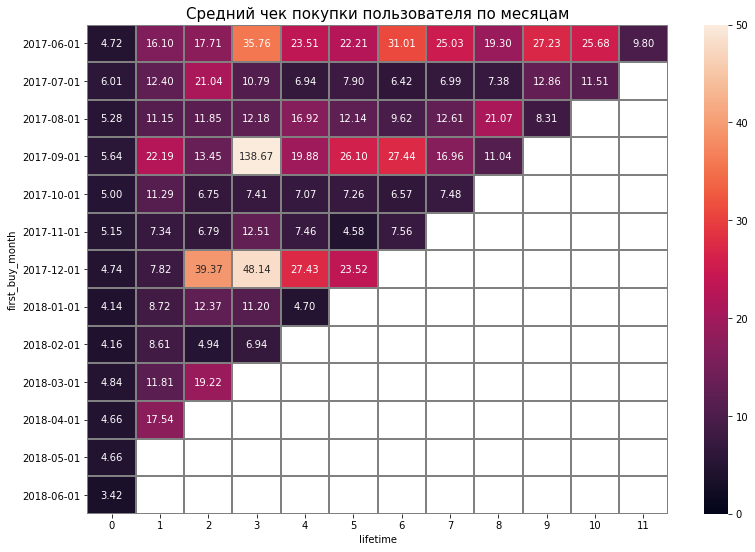

In [47]:
revenue_pivot = revenue_cohort.pivot_table(index='first_buy_month', columns='lifetime', values='revenue_per_user', aggfunc='mean')
plt.figure(figsize=(13, 9))
plt.title('Средний чек покупки пользователя по месяцам', size=15)
sns.heatmap(revenue_pivot, vmin=0, vmax=50, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.show()

In [48]:
print('Средний чек покупки:', int(revenue_cohort['revenue_per_user'].mean()), 'у.е.')

Средний чек покупки: 14 у.е.


Помимо того, что июньская (2017г) когорта делает больше заказов в месяц, так еще и каждый заказ в среднем выходит на бОльшую сумму, относительно других когорт, если рассматривать показатель на протяжении всей жизни когорты.

Выделяются два числа с очень большой суммой среднего чека - на четвертый месяц "жизни" сентябрьской и декабрьской когорт 2017 года. Может быть, среди пользователей этих когорт были какие-то оптовые заказы для больших групп людей, что повлияло на общее среднее значение по месяцу.

- Выясним, как меняется во времени LTV на покупателя по когортам. Помним, что LTV — накопительная метрика. Рассчитаем средний LTV по когортам за 6 месяцев; в расчёт включим когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%.

In [49]:
first_orders = orders_log.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index()
first_orders.columns = ['first_buy_month', 'n_buyers']

In [50]:
first_orders_cohort = orders_log.groupby(['first_buy_month', 'buy_month']).agg({'revenue': 'sum'}).reset_index()

In [51]:
first_orders = first_orders.merge(first_orders_cohort, on='first_buy_month')

In [52]:
# так как маржинальность - 100%, то валовая прибыль будет равна выручке
first_orders['gp'] = first_orders['revenue']
first_orders['age'] = (first_orders['buy_month'] - first_orders['first_buy_month']) / np.timedelta64(1, 'M')
first_orders['age'] = first_orders['age'].round().astype('int')
first_orders['ltv'] = first_orders['gp'] / first_orders['n_buyers']
first_orders['first_buy_month'] = first_orders['first_buy_month'].dt.strftime('%Y-%m-%d')

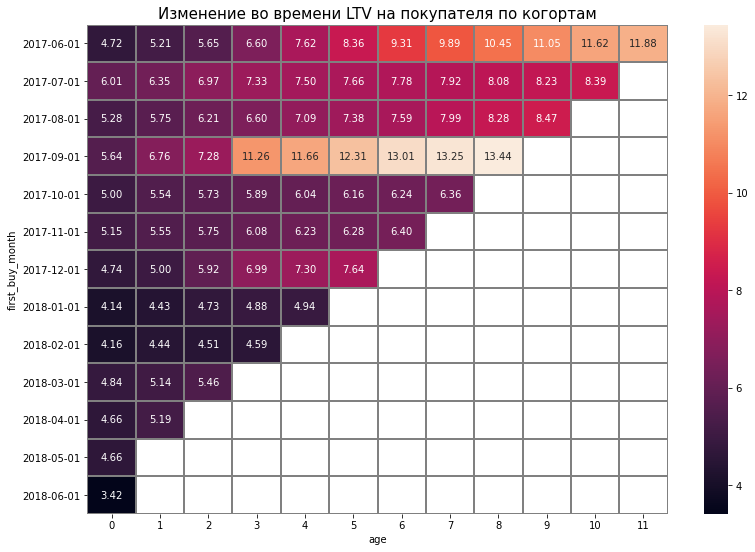

In [53]:
first_orders_pivot = first_orders.pivot_table(index='first_buy_month', columns='age', values='ltv', aggfunc='mean')
first_orders_pivot = first_orders_pivot.cumsum(axis=1).round(2)

plt.figure(figsize=(13, 9))
plt.title('Изменение во времени LTV на покупателя по когортам', size=15)
sns.heatmap(first_orders_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.show()

Самая лояльная оказалась когорта сентября 2017 года - она показывает наибольшую выручку на покупателя за время жизни, хоть и не является наиболее долгоживущей в данном исследовании. То есть когорта июня 2017 года за год не накопила такую выручку на покупателя, как сентябрьская к 9 месяцу "жизни". Может, для этой когорты делают специальную рассылку, которая поддерживает интерес? Но скорее всего в этом случае могли повлиять крупные покупки, гипотеза о которых появилась после рассмотрения среднего чека по месяцам. Когорты, образовавшихся с октября, показывают уже менее интенсивное наращивание выручки с покупателя, а когорты, образовавшиеся после Нового года покупают еще меньше.

Теперь рассчитаем и посмотрим на средний LTV по когортам за 6 месяцев; в расчёт включим когорты, «прожившие» не менее 6 месяцев.

In [54]:
print('Средний LTV по когортам за 6 месяцев:', round(first_orders_pivot[5].mean(),2))

Средний LTV по когортам за 6 месяцев: 7.97


Также посмотрим на LTV по всем возрастам когорт.

In [55]:
print('Средние значения LTV (накопительные) по всем возрастам когорт')
first_orders.pivot_table(index='age', values='ltv', aggfunc='mean').cumsum(axis=0).round(2)

Средние значения LTV (накопительные) по всем возрастам когорт


ltv
age      
0    4.80
1    5.26
2    5.66
3    6.49
4    6.84
5    7.17
6    7.53
7    7.83
8    8.13
9    8.44
10   8.81
11   9.06

Спустя полгода пользования сайтом, клиенты к этому сроку в среднем приносят по 8 у.е. дохода на человека. Если смотреть на самый первый месяц, то получается, что самую крупную покупку клиенты совершают все таки сразу, скорее всего в момент первого обращения к сервису. Дальнейшие покупки, вероятно, происходят уже не каждый месяц, за счет этого наращивание по сумме заказа происходит не так быстро.

**Вывод**

В большинстве случаев пользователям требуется 1 минута с момента первого посещения для того, чтобы совершить покупку. Также есть довольно большая часть "нулевых" продолжительностей между первым визитом и первым заказом, скорее всего это связано с тем, что пользователи оплачивают покупку, например, напрямую через почту и посещение сайта таким пользователям не требуется.

Согласно данным LTV по когортам, больше всего прибыли принесли когорты июня и сентября 2017 года, а вот начиная с октябрьской когорты динамика продаж заметно замедляется.

### 2.3 Маркетинговые метрики <a name=Шаг23></a>

- Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам.

In [56]:
print('Общая сумма расходов на мерткетинг за период:', costs['costs'].sum())

Общая сумма расходов на мерткетинг за период: 329131.62


In [57]:
fig = px.bar(costs.pivot_table(index='source_id', values='costs', aggfunc='sum').reset_index(), x='source_id', y='costs')
fig.update_layout(title='Распределение расходов по рекламным источникам', xaxis_title='Рекламный источник', yaxis_title='Сумма расходов')
fig.show()

За год на маркетинг было потрачено 329131.62 у.е., из них упор был сделан на рекламный источник №3 - почти половина всех потраченных средств. На некоторые источники потратили минимум, например на источники 9 и 10, а на некоторые вовсе не было затрат (с 6 по 8).

- Рассчитаем средний CAC на одного покупателя для всего проекта и для каждого источника трафика.

In [58]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [59]:
first_orders['first_buy_month'] = pd.to_datetime(first_orders['first_buy_month'])

In [60]:
monthly_costs = costs.groupby('month')['costs'].sum().reset_index()
first_orders_costs = pd.merge(first_orders, monthly_costs, left_on='first_buy_month', right_on='month')

In [61]:
first_orders_costs['cac'] = first_orders_costs['costs'] / first_orders_costs['n_buyers']

In [62]:
first_orders_costs_pivot = first_orders_costs.pivot_table(index='month', values='cac', aggfunc='mean').reset_index()
fig = px.line(first_orders_costs_pivot, x='month', y='cac')
fig.update_layout(title='Средний CAC на одного покупателя для всего проекта по месяцам', xaxis_title='Месяц', yaxis_title='CAC')
fig.show()

In [63]:
print('Средний CAC на одного покупателя для всего проекта:', round(first_orders_costs_pivot['cac'].mean(), 2))

Средний CAC на одного покупателя для всего проекта: 9.15


В среднем компания тратит по 9 у.е. для привлечения одного покупателя. Каждый месяц это число разное, возможно траты на маркетинг также отличаются каждый месяц, а также каждый месяц выходит разное количество покупателей. Например в августе 2017 года один покупатель обошелся дороже всего. Такое возможно, когда компания потратилась на рекламу, а привлеклось непропорционально мало новых покупателей. Зато в сентябре и октябре сумма уменьшалась, возможно августовские траты на маркетинг сработали "вдолгую".

Для расчета CAC с разбивкой по источникам трафика будем считать, что "главный" источник - это тот, с которого пользователь совершил первый визит, так как вероятно именно в этот момент он и познакомился с сервисом. Может быть первый раз пользователь перешел по рекламе или через письмо в почте, ознакомился с сайтом, а на покупку решился чуть позже и просто вбил название сайта в поисковик. Таким образом "отработал" именно источник первого визита.

In [64]:
visits_log['first_visit'] = visits_log['first_visit_date'].astype('datetime64[D]')
visits_log['first_buy'] = visits_log['first_buy_date'].astype('datetime64[D]')

In [65]:
visits_2 = visits_log.sort_values('start_ts').groupby('uid').first().reset_index()

In [66]:
first_visit_source = visits_2.groupby(['source_id', 'first_buy']).agg({'uid': 'count'}).reset_index()
# Фиксируем дату первого визита, чтобы найти источник, но для расчета будем брать дату первой покупки

In [67]:
daily_source_costs = costs.groupby(['source_id', 'dt']).agg({'costs': 'sum'}).reset_index()
daily_source_cac = pd.merge(first_visit_source, daily_source_costs, left_on=['source_id', 'first_buy'], right_on=['source_id', 'dt'])

In [68]:
daily_source_cac['cac'] = daily_source_cac['costs'] / daily_source_cac['uid']
daily_source_cac['month'] = daily_source_cac['first_buy'].astype('datetime64[M]')
daily_source_cac_pivot = daily_source_cac.pivot_table(index=['source_id', 'month'], values='cac', aggfunc='mean')

In [69]:
fig = px.line(daily_source_cac_pivot.reset_index(), x='month', y='cac', color='source_id')
fig.update_layout(title='Средний CAC на одного покупателя для каждого источника трафика по месяцам', xaxis_title='Месяц', yaxis_title='CAC')
fig.show()

In [70]:
sourse = daily_source_cac_pivot.reset_index().groupby('source_id')['cac'].mean()
print('Средний CAC на одного покупателя для каждого источника трафика:')
sourse.reset_index()

Средний CAC на одного покупателя для каждого источника трафика:


source_id        cac
0          1   9.504800
1          2  16.314058
2          3  15.566601
3          4   7.259773
4          5   8.345224
5          9   6.774400
6         10   6.497916

По графику с суммарными затратами на маркетинг по источникам, источник 3 сильно выделялся, в него было вложено намного больше средств, по сравнению с остальными. На текущем графике он так резко не выделяется и даже показывает себя лучше, чем источник 2 (в который было вложено более чем в 3 раза меньше). Значит, что большие затраты на источник 3 окупились и довольно большими привлечениями новых покупателей.
Также источник 4 кажется довольно эффективным, второй по суммарным затратам, но CAC низкий - значит источник помог привлечь много покупателей.
Также с низким показателем CAC источники 9 и 10, но и затраты на них были самыми маленькими. Возможно на них стоит обратить внимание и вложить больше средств, если они будут показывать такой же низкий CAC в бОльшем масштабе, то они могут оказаться очень эффективными.

- Рассчитаем ROMI по когортам в разрезе источников. Сравним окупаемость за одинаковые периоды жизни когорт.

In [71]:
orders_log['first_buy'] = orders_log['first_buy_date'].astype('datetime64[D]')
orders_log['buy_date'] = orders_log['buy_ts'].astype('datetime64[D]')

In [72]:
orders_log = orders_log.merge(visits_2[['uid', 'source_id']], how='left', on='uid')

In [73]:
daily_source_romi = orders_log.groupby(['source_id', 'first_buy_month']).agg({'uid': 'count'}).reset_index()
daily_sourse_revenue = orders_log.groupby(['source_id', 'first_buy_month', 'buy_month']).agg({'revenue': 'sum'}).reset_index()
daily_source_romi = daily_source_romi.merge(daily_sourse_revenue, on=['source_id', 'first_buy_month'])
daily_source_romi['age'] = (daily_source_romi['buy_month'] - daily_source_romi['first_buy_month']) / np.timedelta64(1, 'M')
daily_source_romi['age'] = daily_source_romi['age'].round().astype('int')
daily_source_romi['ltv'] = daily_source_romi['revenue'] / daily_source_romi['uid']

In [74]:
cac_mean = daily_source_cac.groupby('source_id')['cac'].mean()

In [75]:
daily_source_romi = daily_source_romi.merge(cac_mean, on='source_id')

In [76]:
daily_source_romi['romi'] = daily_source_romi['ltv'] / daily_source_romi['cac']

In [77]:
daily_source_romi['first_buy_month'] = daily_source_romi['first_buy_month'].dt.strftime('%Y-%m-%d')

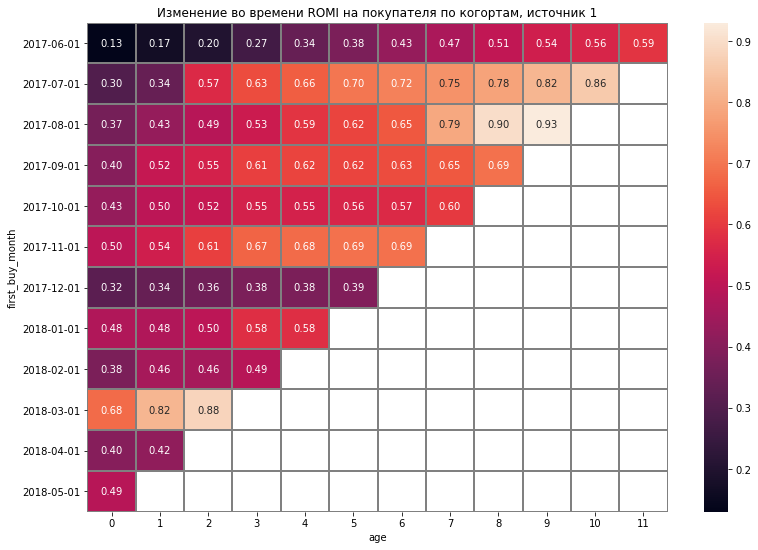

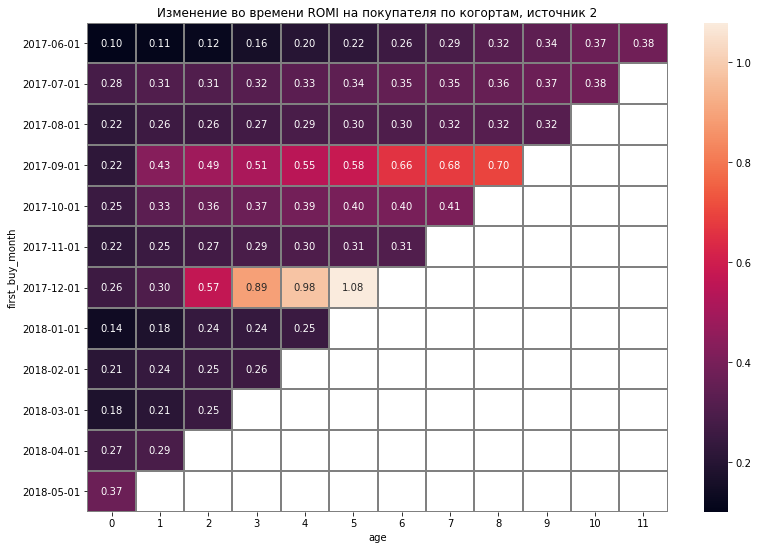

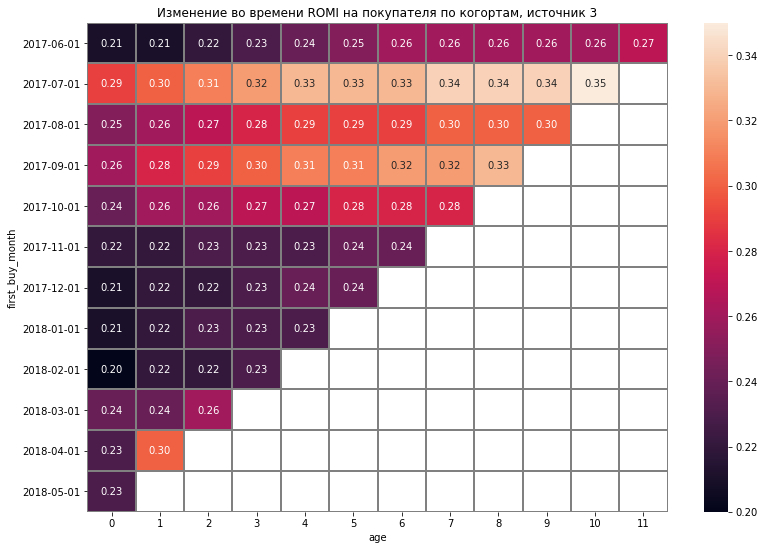

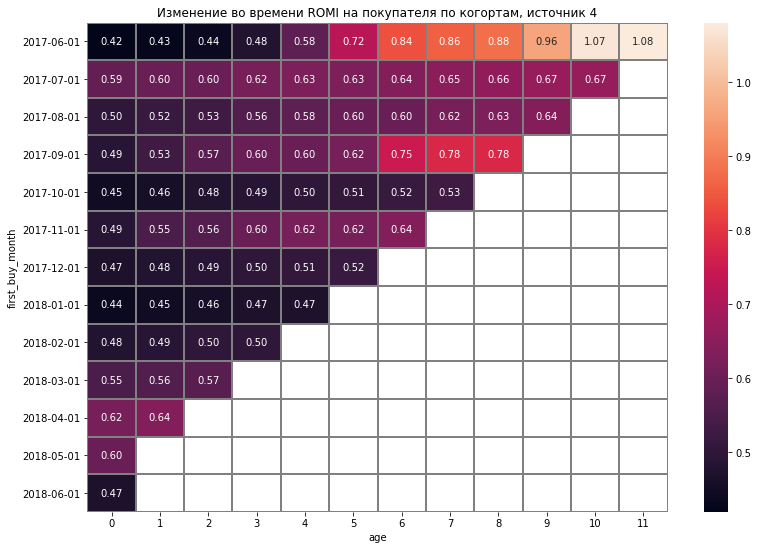

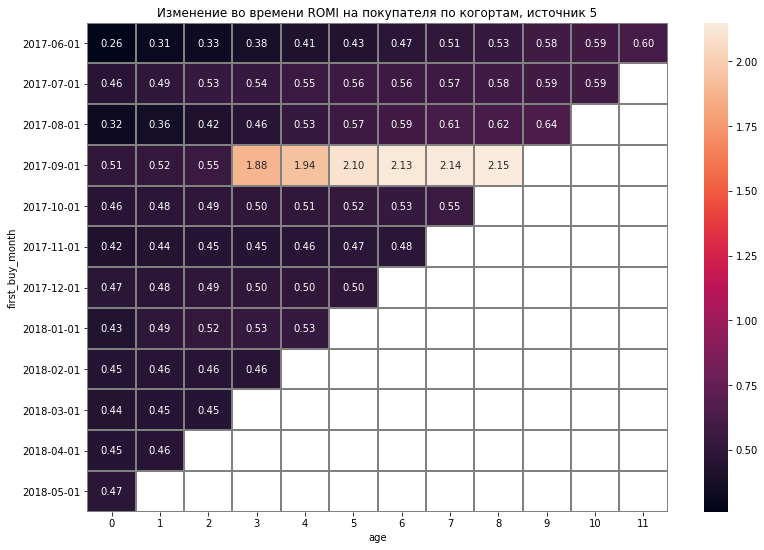

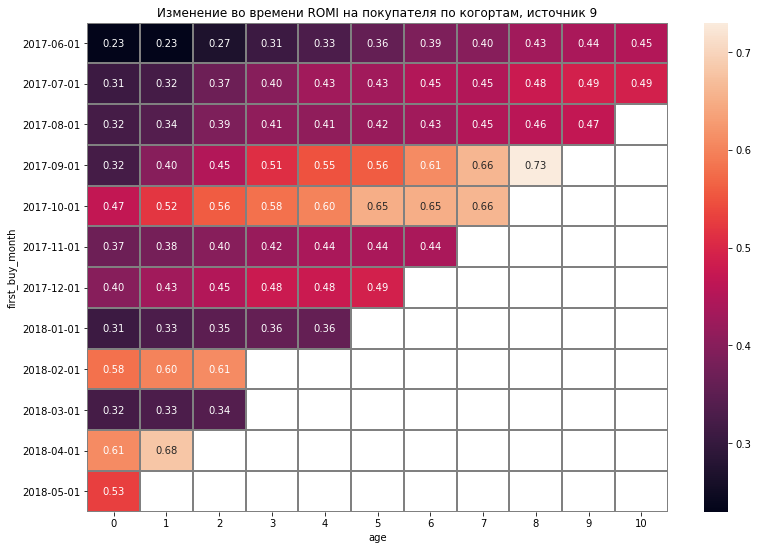

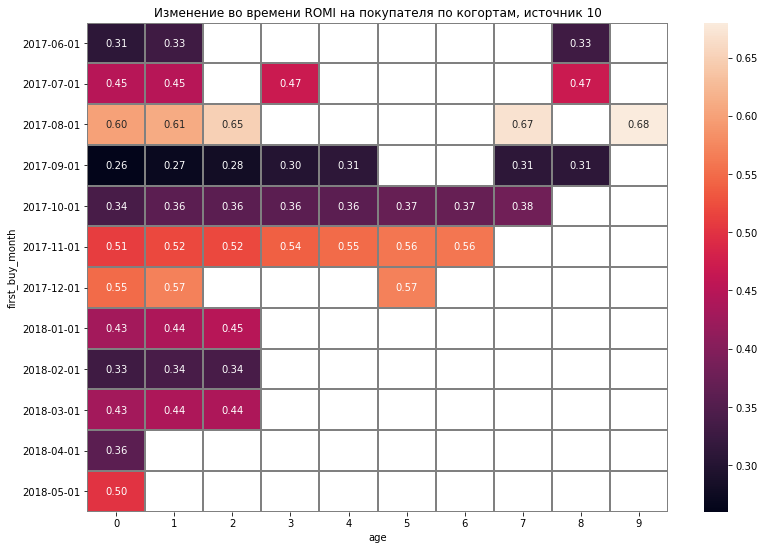

In [79]:
sources = daily_source_romi['source_id'].unique()
for source in sources:
    romi_pivot = daily_source_romi[daily_source_romi['source_id'] == source].pivot_table(index='first_buy_month', columns='age', values='romi', aggfunc='mean')
    romi_pivot = romi_pivot.cumsum(axis=1).round(2)
    plt.figure(figsize=(13, 9))
    plt.title(f'Изменение во времени ROMI на покупателя по когортам, источник {source}')
    sns.heatmap(romi_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')

Очень редко вложения в маркетинговые источники в принципе окупились, только по некоторым отдельным когортам. Одни из них это когорты с большим средним чеком - июньская и сентябрьская 2017 года в своих источниках (4 и 5 соответственно). Но сентябрьская окупилась дважды за первые полгода, а июньская только вышла "в ноль" к концу года своей "жизни". Еще одна окупившаяся когорта - когорта декабря 2017 года, окупила вложения за полгода. Данные когорты можно назвать перспективными.
Если смотреть по источникам в целом, то лучшую динамику показывают 1, 4, 5 и 9 источники.

## Шаг 3. Выводы и рекомендации <a name=Шаг3></a>

- Опишем выводы, которые были сделаны после подсчёта метрик каждого вида: продуктовых, метрик электронной коммерции и маркетинговых.

В среднем, если пользователь посещает сайт, то делает это 1 раз в день и тратит примерно минуту если зашел, чтобы сделать заказ. По два раза в день мало кто заходит. Среднее время между первым визитом и покупкой составляет также минуту в большинстве случаев.
Скорее всего пользователи периодически заходят мониторить новые ближайшие события (DAU и WAU имеют положительную тенденцию за период, а MAU после ноября уменьшается - нет притока новых клиентов, ежедневный трафик обеспечивают старые пользователи), но покупают куда-либо билеты не каждый месяц. Говоря про количество уникальных пользователей, то после первой покупки на второй месяц возвращаются на сайт только 6%. Спустя больше времени процент может немного увеличиваться - большинство людей не планируют покупать билеты куда-либо каждый месяц.

Средний чек на покупателя за весь период составил 14 у.е., а LTV на покупателя, например за первые полгода, составляет примерно 8 у.е. Средний чек за первый месяц ниже, чем в последующих, возможно при знакомстве с сервисом клиенты не хотят делать крупные заказы, а те из них, кто возвращается снова, проявляют больше доверия к сайту и совершают заказы на более крупные суммы.

Сопоставляя графики с общим CAC по месяцам и MAU, можно убедиться, что действительно после значимых затрат на маркетинг в августе, начался большой приток новых пользователей, что продолжалось до ноября.  

- Определим источники трафика, на которые маркетологам стоит делать упор

При выборе более эффективных источников трафика стоит в большей степени учитывать ROMI, нежели CAC. Так как в любом случае любая коммерческая деятельность подразумевает получение прибыли, с одной стороны хорошо, когда с меньшими затратами мы можем привлечь больше покупателей, но также важно, чтобы с привлеченных покупателей доход был больше.
Таким образом обратим внимание на то, с какой динамикой окупаются вложенные затраты, хоть и окупили себя всего 3 отдельные когорты. По такой оценке можно выделить 1, 4, 5 и 9 источники, если дальше развивать указанные источники, то можно привлечь больше пользователей с подобной динамикой ROMI.

- Подведем итоги когортного анализа. Определим самые перспективные для компании когорты клиентов

Есть когорты, которые выделяются на фоне других по ряду метрик: по среднему чеку и LTV это когорты июня и сентября 2017 года, в общем у них самая быстрорастущая динамика по принесенной прибыли. Таблицы с показателем ROMI дополнительно показывают, что данные когорты входят в число окупивших себя когорт. Когорта марта 2018 года (источник 1) близка к тому, чтобы выйти "в ноль", хоть ей всего 3 месяца, когорта декабря 2017 (источник 2) окупилась на полгода - эти когорты также довольно перспективны. На указанные когорты можно обратить внимание для более точечной маркетинговой работы, так как пользователи данных когорт уже отличаются лояльностью и, что немаловажно, делают заказы на бОльшие суммы.